# CNN with MNIST data set

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Convert mnist images to tesnors of 4 dimenstions (# of images,height width,color channel)

In [2]:
transform = transforms.ToTensor()

In [6]:
# Load the dataset from local files
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:11<00:00, 857kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 99.6kB/s]
100%|██████████| 1.65M/1.65M [00:07<00:00, 221kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.24MB/s]


In [7]:
# Load the dataset from local files
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [20]:
 #create a small batch of images
train_loader=DataLoader(train_data,batch_size=10 ,shuffle=True)
test_loader=DataLoader(test_data,batch_size=10 ,shuffle=False)

In [47]:
#Define CNN model
# Describe convo layer and what its doing
#no need to add padding because most of the data is in the middle
conv1= nn.Conv2d(1,6,3,1)
conv2=nn.Conv2d(6,16,3,1)

In [48]:
#grab one image from mnsit
for i,(X_train,y_train) in enumerate(train_data):
    break
X_train.shape

torch.Size([1, 28, 28])

1 batch by 1 image of 28 28

In [49]:
x=X_train.view(1,1,28,28)

first convolution

In [50]:
x=F.relu(conv1(x))

In [51]:
x.shape

torch.Size([1, 6, 26, 26])

Pooling layer

In [52]:
x = F.max_pool2d(x,2,2)

26/2=13

In [53]:
x.shape

torch.Size([1, 6, 13, 13])

DO second convo

In [54]:
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [56]:
x=F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 16, 5, 5])

In [57]:
#Model Class
class convolutionnalNetwork(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.conv1=nn.Conv2d(1,6,3,1)
        self.conv2=nn.Conv2d(6,16,3,1)
        #fully connected layer/layers
        self.fc1=nn.Linear(5*5*16,120) #120 neurons
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10) #has to ends in 10 for 0-9
        
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        
        #second pass
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        
        # Reviews data to fallter
        X=X.view(-1,16*5*5) #negative one so that we can vary the batch size
        
        #fully connected layers
        
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=self.fc3(X)
        return F.log_softmax(X,dim=1)

        
        

In [58]:
#create instance of our model
torch.manual_seed(41)
model =convolutionnalNetwork()

In [59]:
model

convolutionnalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [61]:
# LOss function optimizer
criterion =nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001) # smaller lr ,longer its gonna take to train


In [62]:
# track time
import time
start_time=time.time()

# create variables to track things
epochs=5
train_losses=[]
test_losses=[
]
train_correct=[]
test_correct=[]



#for loops for epochs
for i in range(epochs):
    
    trn_corr=0
    tst_corr=0
    

    #Train
    for b,(X_train,y_train) in enumerate(train_loader):
        b+=1
        y_pred=model(X_train) # no need for flatten because convo1 expects 2d
        loss=criterion(y_pred,y_train)
        
        predicted=torch.max(y_pred.data,1)[1] #add up the number of correct predictions.indexed off the first point
        batch_corr=(predicted==y_train).sum()
        trn_corr+=batch_corr #keep tracks as we go along in training
        #Update params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        #Print results
        if b%600 ==0:
            print(f"Epoch {i} Batch {b} Loss {loss.item()}")
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    
    
    #Tst
    with torch.no_grad() : #No gradients because we dont want to update weights and biases
        for b,(X_test,y_test) in enumerate(test_loader):
            y_val=model(X_test)
            predicted = torch.max(y_val.data,1)[1]
            tst_corr+=(predicted==y_test).sum()
    loss=criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)





current_time=time.time()

total_time=current_time-start_time
print(f"Training time :{total_time/60} minutes")

Epoch 0 Batch 600 Loss 0.16236108541488647
Epoch 0 Batch 1200 Loss 0.16145475208759308
Epoch 0 Batch 1800 Loss 0.5041749477386475
Epoch 0 Batch 2400 Loss 0.14436954259872437
Epoch 0 Batch 3000 Loss 0.006633368786424398
Epoch 0 Batch 3600 Loss 0.35364052653312683
Epoch 0 Batch 4200 Loss 0.0035473357420414686
Epoch 0 Batch 4800 Loss 0.001344313845038414
Epoch 0 Batch 5400 Loss 0.06409706920385361
Epoch 0 Batch 6000 Loss 0.0005210967501625419
Epoch 1 Batch 600 Loss 0.004664862062782049
Epoch 1 Batch 1200 Loss 0.22296497225761414
Epoch 1 Batch 1800 Loss 0.0016253074863925576
Epoch 1 Batch 2400 Loss 0.003696118714287877
Epoch 1 Batch 3000 Loss 0.011839637532830238
Epoch 1 Batch 3600 Loss 0.3428468704223633
Epoch 1 Batch 4200 Loss 0.0257871113717556
Epoch 1 Batch 4800 Loss 0.00033104867907240987
Epoch 1 Batch 5400 Loss 0.0004970162408426404
Epoch 1 Batch 6000 Loss 0.509151816368103
Epoch 2 Batch 600 Loss 0.01782764308154583
Epoch 2 Batch 1200 Loss 0.004009097348898649
Epoch 2 Batch 1800 Loss

# Graph out results !

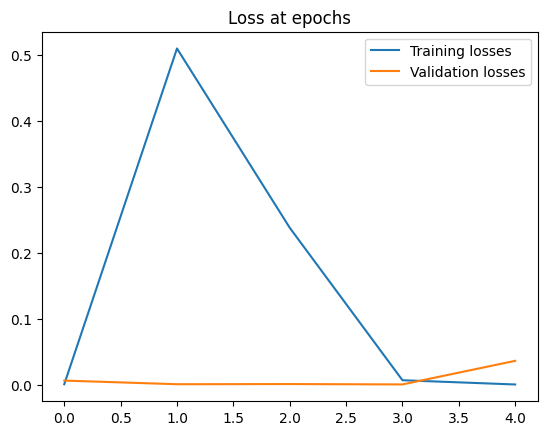

In [63]:
train_losses=[tl.item() for tl in train_losses]
test_losses=[tl.item() for tl in test_losses]
plt.plot(train_losses,label='Training losses')
plt.plot(test_losses,label='Validation losses')
plt.title("Loss at epochs")
plt.legend()

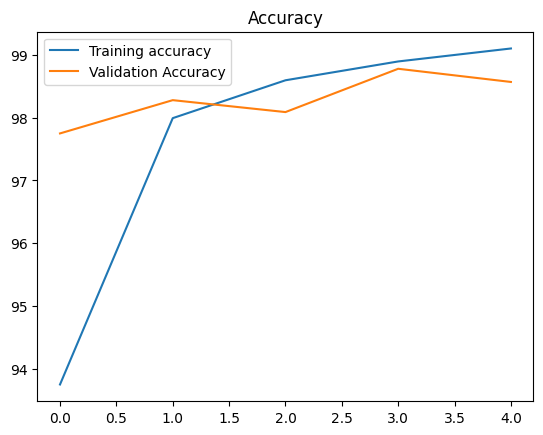

In [65]:
#Graph accuracey at the end of each epochs
plt.plot([t/600 for t in train_correct],label='Training accuracy')
plt.plot([t/100 for t in test_correct],label='Validation Accuracy')
plt.title("Accuracy")
plt.legend()

In [66]:
test_load_everything=DataLoader(test_data,batch_size=10000,shuffle=False)
with torch.no_grad():
    correct=0
    for X_test,y_test,in test_load_everything:
        y_val=model(X_test)
        predicted=torch.max(y_val,1)[1]
        correct +=(predicted==y_test).sum()

In [69]:
# Test for correct
correct.item()/len(test_data) * 100

98.57000000000001